# Data Cleaning, Feature Engineering, and Exploratory Data Analysis

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_regression, RFE, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Load the Dataset

In [47]:
file_path = "./data/gov/transactions_with_interest_final.csv"
df = pd.read_csv(file_path)

# Display first few rows
df.head()

,כתובת,"מ""ר",תאריך עסקה,מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל
0,חטיבת כרמלי 21,59.4,06-04-2025,"1,060,000 ₪",10920-100-27,דירה בבית קומות,3,רביעית,1960.0,5.0,נווה פז,0.0450
1,חטיבת כרמלי 21,59.4,19-12-2018,"600,000 ₪",10920-100-27,דירה בבית קומות,3,רביעית,1960.0,5.0,נווה פז,0.0025
2,יד לבנים 7,68,01-04-2025,"720,000 ₪",12485-15-6,דירה בבית קומות,3,לא ידוע,1940.0,3.0,נווה פז,0.0450
3,יד לבנים 37,44.8,27-03-2025,"645,000 ₪",12482-19-9,דירה בבית קומות,2,ראשונה,1960.0,3.0,נווה פז,0.0450
4,נווה גנים 4,54,25-03-2025,"1,120,000 ₪",10925-216-9,דירה בבית קומות,3,קומה 3,2015.0,8.0,נווה פז,0.0450


## Identify Missing Values

In [48]:
# Define custom missing value conditions
df['שנת בנייה'] = df['שנת בנייה'].replace(0, pd.NA)
df['קומות במבנה'] = df['קומות במבנה'].replace(0, pd.NA)
df['קומה'] = df['קומה'].replace('-', pd.NA)
df['קומה'] = df['קומה'].replace('לא ידוע', pd.NA)
df['חדרים'] = df['חדרים'].replace('לא ידוע', pd.NA)
df['סוג נכס'] = df['סוג נכס'].replace('לא ידוע', pd.NA)
df['מ"ר'] = df['מ"ר'].replace('לא ידוע', pd.NA)
df['כתובת'] = df['כתובת'].replace('ללא כתובת', pd.NA)

# Count missing values per column
missing_counts = df.isna().sum()
missing_counts

כתובת               3690
מ"ר                  338
תאריך עסקה             0
מחיר                   0
גוש/חלקה/תת-חלקה       0
סוג נכס             2137
חדרים               2531
קומה                2966
שנת בנייה           4678
קומות במבנה         6330
שכונה                  0
ריבית בנק ישראל        0
dtype: int64

## Handle Missing Values

For each of these fields, we will use an approach that suits its importance to the model and the amount of missing data.

For the floor & street name features, we chose to fill missing values as “Unknown”, since the missing cases were minimal and we estimate that its impact on the model is relatively low.

For the number of floors in the building and year of construction, which have a greater influence on the apartment price, we invested more effort. We searched for data from other transactions at the same address, and if none was found – we used the median for the same street or neighborhood. For the number of floors in the building, we also made sure that the final value is always greater than or equal to the floor where the unit is located.

### Drop missing square mr records

In [49]:
df = df.dropna(subset=['מ"ר'])

### Fill floor & street name missing values with “Unknown”

In [50]:
df['כתובת'] = df['כתובת'].replace(pd.NA, 'ללא כתובת')

In [51]:
df['קומה'] = df['קומה'].replace(pd.NA, 'לא ידוע')

### Split Address Column into Street and House Number

In [52]:
# Split address into street and house number
df[['רחוב', 'מספר בית']] = df['כתובת'].str.extract(r'(.+?)\s(\d+)$')
df['רחוב'] = df['רחוב'].fillna('רחוב לא ידוע')
df['מספר בית'] = df['מספר בית'].fillna(0).astype(int)
df.drop(columns=['כתובת'], inplace=True)
df.head()

,"מ""ר",תאריך עסקה,מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית
0,59.4,06-04-2025,"1,060,000 ₪",10920-100-27,דירה בבית קומות,3,רביעית,1960.0,5.0,נווה פז,0.0450,חטיבת כרמלי,21
1,59.4,19-12-2018,"600,000 ₪",10920-100-27,דירה בבית קומות,3,רביעית,1960.0,5.0,נווה פז,0.0025,חטיבת כרמלי,21
2,68,01-04-2025,"720,000 ₪",12485-15-6,דירה בבית קומות,3,לא ידוע,1940.0,3.0,נווה פז,0.0450,יד לבנים,7
3,44.8,27-03-2025,"645,000 ₪",12482-19-9,דירה בבית קומות,2,ראשונה,1960.0,3.0,נווה פז,0.0450,יד לבנים,37
4,54,25-03-2025,"1,120,000 ₪",10925-216-9,דירה בבית קומות,3,קומה 3,2015.0,8.0,נווה פז,0.0450,נווה גנים,4


### Fill building year of construction using other transactions at the same address

In [53]:
# Fill missing building year of construction
for idx, row in df[df['שנת בנייה'].isna()].iterrows():
    street = row['רחוב']
    house_number = row['מספר בית']
    # Try to fill from other transactions at same address
    candidates = df[(df['רחוב'] == street) & (df['מספר בית'] == house_number) & df['שנת בנייה'].notna()]['שנת בנייה']
    if not candidates.empty:
        df.at[idx, 'שנת בנייה'] = candidates.iloc[0]
    else:
        # Use median for same street or neighborhood
        street_median = df[(df['רחוב'] == street) & df['שנת בנייה'].notna()]['שנת בנייה'].median()
        if pd.notna(street_median):
            df.at[idx, 'שנת בנייה'] = street_median
        else:
            neighborhood = row['שכונה']
            neigh_median = df[(df['שכונה'] == neighborhood) & df['שנת בנייה'].notna()]['שנת בנייה'].median()
            df.at[idx, 'שנת בנייה'] = neigh_median

### Fill property type using other transactions at the same address

In [54]:
# Fill missing building year of construction
for idx, row in df[df['סוג נכס'].isna()].iterrows():
    street = row['רחוב']
    house_number = row['מספר בית']
    # Try to fill from other transactions at same address
    candidates = df[(df['רחוב'] == street) & (df['מספר בית'] == house_number) & df['סוג נכס'].notna()]['סוג נכס']
    if not candidates.empty:
        df.at[idx, 'סוג נכס'] = candidates.iloc[0]
    else:
        # Use majority for same street
        street_mode = df[(df['רחוב'] == street) & df['סוג נכס'].notna()]['סוג נכס'].mode()
        if not street_mode.empty:
            df.at[idx, 'סוג נכס'] = street_mode.iloc[0]
        else:
            # Use majority for same neighborhood
            neighborhood = row['שכונה']
            neigh_mode = df[(df['שכונה'] == neighborhood) & df['סוג נכס'].notna()]['סוג נכס'].mode()
            if not neigh_mode.empty:
                df.at[idx, 'סוג נכס'] = neigh_mode.iloc[0]

### Convert Floor Column to Numeric

In [55]:
floor_mapping = {
    'מרתף': -1, 'מקלט': -1, 'תת מרתף': -2, 'תת-מרתף': -2,
    'קרקע': 0, 'חצר': 0, 'קוטצז': 0, 'ביניים': 0, 'מסד': 0, 'עמודים': 0, 'חניה': 0, 'כניסה': 0, 'גלריה': 0, 'עליונה': 1,

    'ראשונה': 1, 'א': 1, 'ב': 2, 'שניה': 2, 'שנייה': 2, 'שני': 2, 'שני׳ה': 2,
    'שלישית': 3, 'שלשית': 3, 'שלש': 3, 'שלוש': 3, 'ג': 3, 'שלש-עשרה': 13,
    'רביעית': 4, 'רבעית': 4, 'ארבע': 4, 'חמש': 5, 'חמישית': 5, 'שש': 6, 'שישית': 6, 'ששית': 6,
    'שביעית': 7, 'שבע': 7, 'שמונה': 8, 'שמינית': 8, 'תשיעית': 9, 'תשע': 9,
    'עשירית': 10, 'עשר': 10, 'אחת עשרה': 11, 'אחד עשר': 11, 'אחת-עשרה': 11, 'אחד-עשר': 11,
    'שתים עשרה': 12, 'שתיים עשרה': 12, 'שנים עשר': 12, 'שתים-עשרה': 12,
    'שלוש עשרה': 13, 'שלש עשרה': 13, 'שלוש-עשרה': 13,
    'ארבע עשרה': 14, 'ארבעה עשר': 14, 'ארבע-עשרה': 14,
    'חמש עשרה': 15, 'חמש-עשרה': 15,
    'שש עשרה': 16, 'שש-עשרה': 16,
    'שבע עשרה': 17, 'שבע-עשרה': 17,
    'שמונה עשרה': 18, 'שמונה-עשרה': 18,
    'תשע עשרה': 19, 'תשע-עשרה': 19,
    'עשרים': 20, 'עשרים ואחת': 21, 'עשרים ושתים': 22, 'עשרים ושתיים': 22, 'עשרים ושלוש': 23
}

In [56]:
def clean_floor(floor_str):
    if floor_str == 'לא ידוע':
        return 0

    s = str(floor_str)
    s = s.replace('-', ' ')
    s = s.replace('+', ' ')
    s = s.replace(',', ' ')
    s = s.replace('/', ' ')
    s = s.replace(',', ' ')
    s = s.replace('\'', '')
    s = s.replace('קומה', '').replace('קומת', '').replace('קומות', '')
    s = s.strip()

    # split if there are multiple parts
    parts = s.split()
    found_numbers = []

    for part in parts:
        match = re.search(r'\d+', part)
        if match:
            found_numbers.append(int(match.group()))
        else:
            for key in floor_mapping:
                if key in part:
                    found_numbers.append(floor_mapping[key])
                    break

    if found_numbers:
        return max(found_numbers)
    else:
        return 0

In [57]:
df['קומה'] = df['קומה'].apply(clean_floor)
df.head()

,"מ""ר",תאריך עסקה,מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית
0,59.4,06-04-2025,"1,060,000 ₪",10920-100-27,דירה בבית קומות,3,2,1960.0,5.0,נווה פז,0.0450,חטיבת כרמלי,21
1,59.4,19-12-2018,"600,000 ₪",10920-100-27,דירה בבית קומות,3,2,1960.0,5.0,נווה פז,0.0025,חטיבת כרמלי,21
2,68,01-04-2025,"720,000 ₪",12485-15-6,דירה בבית קומות,3,0,1940.0,3.0,נווה פז,0.0450,יד לבנים,7
3,44.8,27-03-2025,"645,000 ₪",12482-19-9,דירה בבית קומות,2,1,1960.0,3.0,נווה פז,0.0450,יד לבנים,37
4,54,25-03-2025,"1,120,000 ₪",10925-216-9,דירה בבית קומות,3,3,2015.0,8.0,נווה פז,0.0450,נווה גנים,4


### Fill building floors using other transactions at the same address

In [58]:
# Fill missing number of floors in building
for idx, row in df[df['קומות במבנה'].isna()].iterrows():
    street = row['רחוב']
    house_number = row['מספר בית']
    # Try to fill from other transactions at same address
    candidates = df[(df['רחוב'] == street) & (df['מספר בית'] == house_number) & df['קומות במבנה'].notna()]['קומות במבנה']
    if not candidates.empty:
        value = candidates.iloc[0]
    else:
        # Use median for same street or neighborhood
        street_median = df[(df['רחוב'] == street) & df['קומות במבנה'].notna()]['קומות במבנה'].median()
        if pd.notna(street_median):
            value = street_median
        else:
            neighborhood = row['שכונה']
            neigh_median = df[(df['שכונה'] == neighborhood) & df['קומות במבנה'].notna()]['קומות במבנה'].median()
            value = neigh_median
    # Ensure final value is always >= floor
    floor = row['קומה']
    if pd.notna(value) and pd.notna(floor):
        value = max(value, floor)
    df.at[idx, 'קומות במבנה'] = value

### Fill rooms using square mr

In [24]:
# Fill missing rooms using sqm and similar address/street
for idx, row in df[df['חדרים'].isna()].iterrows():
    street = row['רחוב']
    house_number = row['מספר בית']
    neighborhood = row['שכונה']
    sqm = pd.to_numeric(row['מ"ר'], errors='coerce')
    
    # 1. Try same address (street + house number)
    candidates = df[(df['רחוב'] == street) & (df['מספר בית'] == house_number) & df['חדרים'].notna() & df['מ"ר'].notna()]
    if not candidates.empty:
        avg_sqm_per_room = (pd.to_numeric(candidates['מ"ר'], errors='coerce') / pd.to_numeric(candidates['חדרים'], errors='coerce')).mean()
    else:
        # 2. Try same street
        candidates = df[(df['רחוב'] == street) & df['חדרים'].notna() & df['מ"ר'].notna()]
        if not candidates.empty:
            avg_sqm_per_room = (pd.to_numeric(candidates['מ"ר'], errors='coerce') / pd.to_numeric(candidates['חדרים'], errors='coerce')).mean()
        else:
            # 3. Use neighborhood average
            candidates = df[(df['שכונה'] == neighborhood) & df['חדרים'].notna() & df['מ"ר'].notna()]
            avg_sqm_per_room = (pd.to_numeric(candidates['מ"ר'], errors='coerce') / pd.to_numeric(candidates['חדרים'], errors='coerce')).mean()
    
    # Estimate rooms
    if avg_sqm_per_room > 0:
        estimated_rooms = round(sqm / avg_sqm_per_room, 0)
        df.at[idx, 'חדרים'] = estimated_rooms

In [25]:
# Count missing values per column after filling
df.isna().sum()

מ"ר                 0
תאריך עסקה          0
מחיר                0
גוש/חלקה/תת-חלקה    0
סוג נכס             0
חדרים               0
קומה                0
שנת בנייה           0
קומות במבנה         0
שכונה               0
ריבית בנק ישראל     0
רחוב                0
מספר בית            0
dtype: int64

## Extract Year and Month from Transaction Date

In [26]:
# Convert 'תאריך עסקה' to datetime
df['תאריך עסקה'] = pd.to_datetime(df['תאריך עסקה'], format='%d-%m-%Y', errors='coerce')
df['שנת עסקה'] = df['תאריך עסקה'].dt.year
df['חודש עסקה'] = df['תאריך עסקה'].dt.month

# Drop original date column
df.drop(columns=['תאריך עסקה'], inplace=True)

df.head()

,"מ""ר",מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית,שנת עסקה,חודש עסקה
0,59.4,"1,060,000 ₪",10920-100-27,דירה בבית קומות,3,2,1960.0,5.0,נווה פז,0.0450,חטיבת כרמלי,21,2025,4
1,59.4,"600,000 ₪",10920-100-27,דירה בבית קומות,3,2,1960.0,5.0,נווה פז,0.0025,חטיבת כרמלי,21,2018,12
2,68,"720,000 ₪",12485-15-6,דירה בבית קומות,3,0,1940.0,3.0,נווה פז,0.0450,יד לבנים,7,2025,4
3,44.8,"645,000 ₪",12482-19-9,דירה בבית קומות,2,1,1960.0,3.0,נווה פז,0.0450,יד לבנים,37,2025,3
4,54,"1,120,000 ₪",10925-216-9,דירה בבית קומות,3,3,2015.0,8.0,נווה פז,0.0450,נווה גנים,4,2025,3


## Convert Property Type to Numeric

In [27]:
df['סוג נכס'] = df['סוג נכס'].astype('category').cat.codes
df.head()

,"מ""ר",מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית,שנת עסקה,חודש עסקה
0,59.4,"1,060,000 ₪",10920-100-27,6,3,2,1960.0,5.0,נווה פז,0.0450,חטיבת כרמלי,21,2025,4
1,59.4,"600,000 ₪",10920-100-27,6,3,2,1960.0,5.0,נווה פז,0.0025,חטיבת כרמלי,21,2018,12
2,68,"720,000 ₪",12485-15-6,6,3,0,1940.0,3.0,נווה פז,0.0450,יד לבנים,7,2025,4
3,44.8,"645,000 ₪",12482-19-9,6,2,1,1960.0,3.0,נווה פז,0.0450,יד לבנים,37,2025,3
4,54,"1,120,000 ₪",10925-216-9,6,3,3,2015.0,8.0,נווה פז,0.0450,נווה גנים,4,2025,3


## Convert Price to Numeric

In [28]:
df['מחיר'] = df['מחיר'].str.replace('[^\d]', '', regex=True).astype(float)
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\orifr\AppData\Local\Temp\ipykernel_20420\1309275127.py:1: SyntaxWarning: invalid escape sequence '\d'
  df['מחיר'] = df['מחיר'].str.replace('[^\d]', '', regex=True).astype(float)


,"מ""ר",מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית,שנת עסקה,חודש עסקה
0,59.4,1060000.0,10920-100-27,6,3,2,1960.0,5.0,נווה פז,0.0450,חטיבת כרמלי,21,2025,4
1,59.4,600000.0,10920-100-27,6,3,2,1960.0,5.0,נווה פז,0.0025,חטיבת כרמלי,21,2018,12
2,68,720000.0,12485-15-6,6,3,0,1940.0,3.0,נווה פז,0.0450,יד לבנים,7,2025,4
3,44.8,645000.0,12482-19-9,6,2,1,1960.0,3.0,נווה פז,0.0450,יד לבנים,37,2025,3
4,54,1120000.0,10925-216-9,6,3,3,2015.0,8.0,נווה פז,0.0450,נווה גנים,4,2025,3


## Convert Neighborhood to Numeric

In [29]:
df['שכונה'] = df['שכונה'].astype('category').cat.codes
df.head()

,"מ""ר",מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית,שנת עסקה,חודש עסקה
0,59.4,1060000.0,10920-100-27,6,3,2,1960.0,5.0,17,0.0450,חטיבת כרמלי,21,2025,4
1,59.4,600000.0,10920-100-27,6,3,2,1960.0,5.0,17,0.0025,חטיבת כרמלי,21,2018,12
2,68,720000.0,12485-15-6,6,3,0,1940.0,3.0,17,0.0450,יד לבנים,7,2025,4
3,44.8,645000.0,12482-19-9,6,2,1,1960.0,3.0,17,0.0450,יד לבנים,37,2025,3
4,54,1120000.0,10925-216-9,6,3,3,2015.0,8.0,17,0.0450,נווה גנים,4,2025,3


## Create new features

In [30]:
def create_enhanced_dataset(input_df):
    """
    Take DataFrame with Hebrew columns, add advanced features, and save enhanced dataset
    
    Parameters:
    input_df (pd.DataFrame): Input DataFrame with Hebrew columns
    
    Returns:
    pd.DataFrame: Enhanced DataFrame with new features
    """
    
    print(f"Processing DataFrame with {len(input_df):,} rows")
    
    # Work with a copy to avoid modifying the original
    df = input_df.copy()
    
    # Work directly with Hebrew column names - no duplicates created
    df['מ"ר'] = pd.to_numeric(df['מ"ר'], errors='coerce')
    df['מחיר'] = pd.to_numeric(df['מחיר'], errors='coerce')
    df['חדרים'] = pd.to_numeric(df['חדרים'], errors='coerce')
    df['שנת בנייה'] = pd.to_numeric(df['שנת בנייה'], errors='coerce')
    df['קומות במבנה'] = pd.to_numeric(df['קומות במבנה'], errors='coerce')
    df['ריבית בנק ישראל'] = pd.to_numeric(df['ריבית בנק ישראל'], errors='coerce')
    df['שנת עסקה'] = pd.to_numeric(df['שנת עסקה'], errors='coerce')
    df['חודש עסקה'] = pd.to_numeric(df['חודש עסקה'], errors='coerce')
    
    # Create transaction_date from year and month columns
    print("Creating transaction dates from year/month...")
    
    # Check for invalid months
    invalid_months = df[(df['חודש עסקה'] < 1) | (df['חודש עסקה'] > 12)]['חודש עסקה'].value_counts()
    if len(invalid_months) > 0:
        print(f"Invalid months found: {invalid_months.to_dict()}")
    
    # Check for invalid years
    invalid_years = df[(df['שנת עסקה'] < 1900) | (df['שנת עסקה'] > 2030)]['שנת עסקה'].value_counts()
    if len(invalid_years) > 0:
        print(f"Invalid years found: {invalid_years.head().to_dict()}")
    
    try:
        # Method 1: Create proper DataFrame with explicit columns
        # Only use rows where both year and month are valid
        valid_date_mask = (
            df['שנת עסקה'].notna() & 
            df['חודש עסקה'].notna() & 
            (df['חודש עסקה'] >= 1) & 
            (df['חודש עסקה'] <= 12) &
            (df['שנת עסקה'] >= 1900) & 
            (df['שנת עסקה'] <= 2030)
        )
        
        # Initialize with NaT
        df['transaction_date'] = pd.NaT
        
        # Only create dates for valid combinations
        if valid_date_mask.any():
            date_df = pd.DataFrame({
                'year': df.loc[valid_date_mask, 'שנת עסקה'].astype(int),
                'month': df.loc[valid_date_mask, 'חודש עסקה'].astype(int),
                'day': 1
            })
            df.loc[valid_date_mask, 'transaction_date'] = pd.to_datetime(date_df, errors='coerce')
        
    except Exception as e:
        print(f"Method 1 failed: {e}")
        print("Trying alternative method...")
        
        # Method 2: String-based approach with validation
        df['transaction_date'] = pd.NaT
        valid_mask = (df['שנת עסקה'].notna() & df['חודש עסקה'].notna())
        
        if valid_mask.any():
            df['date_string'] = (df['שנת עסקה'].astype(str) + '-' + 
                                df['חודש עסקה'].astype(str).str.zfill(2) + '-01')
            df.loc[valid_mask, 'transaction_date'] = pd.to_datetime(
                df.loc[valid_mask, 'date_string'], format='%Y-%m-%d', errors='coerce')
            df = df.drop('date_string', axis=1)  # Clean up temporary column
    
    # Check date reconstruction
    valid_dates = df['transaction_date'].notna().sum()
    invalid_dates = df['transaction_date'].isna().sum()
    print(f"Successfully created: {valid_dates:,} dates")
    if invalid_dates > 0:
        print(f"Failed to create: {invalid_dates:,} dates")
    
    # Fill any missing dates with median
    if invalid_dates > 0:
        median_date = df['transaction_date'].median()
        df['transaction_date'] = df['transaction_date'].fillna(median_date)
        print(f"Filled {invalid_dates:,} missing dates with median")
    
    # Create basic derived features
    print("Creating basic derived features...")
    df['price_per_sqm'] = df['מחיר'] / df['מ"ר']
    df['building_age'] = 2025 - df['שנת בנייה']
    df['sqm_per_room'] = df['מ"ר'] / df['חדרים']
    df['year'] = df['transaction_date'].dt.year
    df['month'] = df['transaction_date'].dt.month
    df['year_month'] = df['year'].astype(str) + '_' + df['month'].astype(str).str.zfill(2)
    
    print("Creating advanced features...")
    
    # 1. Size vs Property Type
    property_type_avg_sqm = df.groupby('סוג נכס')['מ"ר'].transform('mean')
    df['size_vs_property_type'] = df['מ"ר'] - property_type_avg_sqm
    
    # 2. Size vs Neighborhood
    neighborhood_sqm_mean = df.groupby('שכונה')['מ"ר'].transform('mean')
    df['size_vs_neighborhood'] = df['מ"ר'] - neighborhood_sqm_mean
    
    # 3. Price vs Neighborhood Median
    neighborhood_price_median = df.groupby('שכונה')['price_per_sqm'].transform('median')
    df['price_vs_neighborhood_median'] = ((df['price_per_sqm'] - neighborhood_price_median) / 
                                          neighborhood_price_median)
    
    # 4. Building Age vs Neighborhood Average
    neighborhood_age_mean = df.groupby('שכונה')['building_age'].transform('mean')
    df['building_age_vs_neighborhood'] = df['building_age'] - neighborhood_age_mean
    
    # 5. Interest Rate Deviation (12-month lookback)
    print("Calculating 12-month interest rate deviation...")
    
    df_sorted = df.sort_values('transaction_date').copy()
    df_sorted = df_sorted.set_index('transaction_date')
    
    # Rolling calculation
    df_sorted['rate_12m_avg'] = df_sorted['ריבית בנק ישראל'].rolling(
        window='365D', min_periods=30).mean().shift(1)
    
    df_sorted['interest_rate_deviation'] = df_sorted['ריבית בנק ישראל'] - df_sorted['rate_12m_avg']
    
    # Reset index and merge back
    df_sorted = df_sorted.reset_index()
    df = df_sorted.copy()
    
    # Clean up intermediate columns we no longer need
    columns_to_drop = ['transaction_date', 'year', 'month', 'year_month', 'rate_12m_avg']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Final cleanup - only drop rows where critical fields are missing
    critical_fields = ['מחיר', 'מ"ר', 'שכונה']  # Using Hebrew column names
    before_critical_clean = len(df)
    df = df.dropna(subset=critical_fields)
    after_critical_clean = len(df)
    
    if before_critical_clean != after_critical_clean:
        print(f"Removed {before_critical_clean - after_critical_clean:,} rows missing critical data")
    
    # Summary
    new_features = [
        'size_vs_property_type', 'size_vs_neighborhood', 'price_vs_neighborhood_median',
        'building_age_vs_neighborhood', 'interest_rate_deviation'
    ]
    
    print(f"Final dataset: {len(df):,} rows")
    print(f"Total features: {len(df.columns)} columns")
    print(f"Added features: {len(new_features)}")
    
    return df

In [32]:
df = create_enhanced_dataset(df)
df.head()

Processing DataFrame with 45,184 rows
Creating transaction dates from year/month...
Successfully created: 45,184 dates
Creating basic derived features...
Creating advanced features...
Calculating 12-month interest rate deviation...
Final dataset: 45,184 rows
Total features: 22 columns
Added features: 5


,"מ""ר",מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,...,שנת עסקה,חודש עסקה,price_per_sqm,building_age,sqm_per_room,size_vs_property_type,size_vs_neighborhood,price_vs_neighborhood_median,building_age_vs_neighborhood,interest_rate_deviation
0,82.50,614000.0,11215-10-26,6,4.0,2,1970.0,8.0,10,0.134,...,1998,1,7442.424242,55.0,20.625000,0.056076,14.237213,-0.420119,0.520278,NaN
1,63.03,627000.0,11191-19-21,6,3.0,2,1960.0,4.0,26,0.134,...,1998,1,9947.643979,65.0,21.010000,-19.413924,-25.163882,-0.199615,12.549404,NaN
2,153.63,1591000.0,11192-150-4,6,6.0,1,1986.0,2.0,31,0.134,...,1998,1,10356.050251,39.0,25.605000,71.186076,71.666455,-0.110139,-16.066940,NaN
3,46.00,318000.0,10881-14-44,6,3.0,2,1960.0,7.0,10,0.134,...,1998,1,6913.043478,65.0,15.333333,-36.443924,-22.262787,-0.461366,10.520278,NaN
4,70.20,674000.0,10806-58-6,6,3.0,3,1967.0,3.0,12,0.134,...,1998,1,9601.139601,58.0,23.400000,-12.243924,-27.586361,-0.393475,5.455086,NaN


## Split Data into Features (X) and Target (y)

In [33]:
# Define target and features
y = df['מחיר']
X = df.drop(columns=['מחיר'])

## Save before model

In [34]:
# Save the manipulated DataFrame to a CSV file
df.to_csv('output/processed_data.csv', index=False)

In [7]:
df = pd.read_csv('output/processed_data.csv').copy()

In [8]:
# Examine the processed data structure
print(f"DataFrame shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nTarget columns available:")
target_candidates = ['מחיר', 'SalePrice', 'price', 'Price']
for col in target_candidates:
    if col in df.columns:
        print(f"  - {col}: {df[col].dtype}")
        
print(f"\nData types:")
print(df.dtypes.value_counts())

DataFrame shape: (45184, 22)
Columns: ['מ"ר', 'מחיר', 'גוש/חלקה/תת-חלקה', 'סוג נכס', 'חדרים', 'קומה', 'שנת בנייה', 'קומות במבנה', 'שכונה', 'ריבית בנק ישראל', 'רחוב', 'מספר בית', 'שנת עסקה', 'חודש עסקה', 'price_per_sqm', 'building_age', 'sqm_per_room', 'size_vs_property_type', 'size_vs_neighborhood', 'price_vs_neighborhood_median', 'building_age_vs_neighborhood', 'interest_rate_deviation']

Target columns available:
  - מחיר: float64

Data types:
float64    14
int64       6
object      2
Name: count, dtype: int64


In [17]:
# Feature Selection Configuration (adapted from feature_selection_minimal.py)
TARGET = 'מחיר'  # Hebrew price column
N_TOP_MI = 15    # top K for Mutual Information
N_FINAL = 12     # features to keep in wrapper methods

def load_and_preprocess_for_selection(df, target_col):
    """Prepare data for feature selection - keep numeric features only."""
    # Get numeric columns only
    numeric = df.select_dtypes(include=[np.number])
    
    # Separate features and target
    X = numeric.drop([target_col], axis=1, errors='ignore') 
    y = numeric[target_col]
    
    # Remove any ID-like columns if they exist
    id_cols = [col for col in X.columns if 'id' in col.lower() or 'index' in col.lower()]
    if id_cols:
        X = X.drop(id_cols, axis=1)
        print(f"Removed ID columns: {id_cols}")
    
    # Remove price_per_sqm as it's derived from the target variable (data leakage)
    if 'price_per_sqm' in X.columns:
        X = X.drop('price_per_sqm', axis=1)
        print(f"Removed 'price_per_sqm' to prevent data leakage (derived from target)")
    
    return X, y

def variance_filter_minimal(X, thresh=0.0):
    """Filter features with low variance."""
    vt = VarianceThreshold(threshold=thresh)
    X_new = vt.fit_transform(X)
    cols = X.columns[vt.get_support()]
    return pd.DataFrame(X_new, columns=cols, index=X.index)

def pearson_filter_minimal(X, y, thr=0.3):
    """Filter features based on Pearson correlation with target."""
    corrs = X.corrwith(y).abs()
    selected = corrs[corrs > thr].index.tolist()
    return selected, corrs

def mi_filter_minimal(X, y, k=N_TOP_MI):
    """Filter features using mutual information."""
    k = min(k, X.shape[1])  # Ensure k doesn't exceed number of features
    skb = SelectKBest(mutual_info_regression, k=k).fit(X, y)
    feats = X.columns[skb.get_support()].tolist()
    scores = dict(zip(feats, skb.scores_[skb.get_support()]))
    return feats, scores

def rfe_wrapper_minimal(X, y, n=N_FINAL):
    """Recursive Feature Elimination with Random Forest."""
    n = min(n, X.shape[1])  # Ensure n doesn't exceed number of features
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rfe = RFE(rf, n_features_to_select=n)
    rfe.fit(X, y)
    return X.columns[rfe.get_support()].tolist()

def sfs_wrapper_minimal(X, y, n=N_FINAL):
    """Sequential Feature Selection with Linear Regression."""
    n = min(n, X.shape[1])  # Ensure n doesn't exceed number of features
    lr = LinearRegression()
    sfs = SequentialFeatureSelector(lr, n_features_to_select=n, direction='forward', cv=3, scoring='r2')
    sfs.fit(X, y)
    return X.columns[sfs.get_support()].tolist()

print("Feature selection functions defined successfully!")

Feature selection functions defined successfully!


In [18]:
# Step 1: Load and preprocess data for feature selection
print('Step 1: Preparing data for feature selection...')
X_raw, y = load_and_preprocess_for_selection(df, TARGET)
print(f'Original features: {X_raw.shape[1]}')
print(f'Target: {TARGET} (shape: {y.shape})')

# Check for infinite values and very large numbers
print('\nChecking for problematic values...')
inf_cols = []
for col in X_raw.columns:
    if np.isinf(X_raw[col]).any():
        inf_count = np.isinf(X_raw[col]).sum()
        print(f'  {col}: {inf_count} infinite values')
        inf_cols.append(col)

# Replace infinite values with NaN
if inf_cols:
    print(f'Replacing infinite values with NaN in {len(inf_cols)} columns')
    X_raw = X_raw.replace([np.inf, -np.inf], np.nan)

# Check for very large values (> 1e10)
large_vals = (X_raw.abs() > 1e10).any()
if large_vals.any():
    print(f'Columns with very large values: {large_vals[large_vals].index.tolist()}')

# Handle missing values
print(f'\nHandling missing values...')
missing_before = X_raw.isnull().sum().sum()
X_raw = X_raw.fillna(X_raw.median())
print(f'Filled {missing_before} missing values with median')

# Remove any remaining problematic rows
X_raw = X_raw.replace([np.inf, -np.inf], np.nan).dropna()
y = y[X_raw.index]  # Keep corresponding target values
print(f'Final shape after cleaning: X={X_raw.shape}, y={y.shape}')

# Step 2: Apply variance filter
print(f'\nStep 2: Applying variance filter...')
X_variance = variance_filter_minimal(X_raw)
print(f'Features after variance filter: {X_variance.shape[1]} (removed {X_raw.shape[1] - X_variance.shape[1]})')
print(f'Remaining features: {list(X_variance.columns)}')

Step 1: Preparing data for feature selection...
Removed 'price_per_sqm' to prevent data leakage (derived from target)
Original features: 18
Target: מחיר (shape: (45184,))

Checking for problematic values...
  sqm_per_room: 97 infinite values
Replacing infinite values with NaN in 1 columns

Handling missing values...
Filled 127 missing values with median
Final shape after cleaning: X=(45184, 18), y=(45184,)

Step 2: Applying variance filter...
Features after variance filter: 18 (removed 0)
Remaining features: ['מ"ר', 'סוג נכס', 'חדרים', 'קומה', 'שנת בנייה', 'קומות במבנה', 'שכונה', 'ריבית בנק ישראל', 'מספר בית', 'שנת עסקה', 'חודש עסקה', 'building_age', 'sqm_per_room', 'size_vs_property_type', 'size_vs_neighborhood', 'price_vs_neighborhood_median', 'building_age_vs_neighborhood', 'interest_rate_deviation']


In [19]:
# Step 3: Apply Pearson correlation filter
print('Step 3: Applying Pearson correlation filter...')
pearson_feats, corrs = pearson_filter_minimal(X_variance, y, thr=0.3)
print(f'Features with |correlation| > 0.3: {len(pearson_feats)}')
print(f'Pearson selected features: {pearson_feats}')

# Show correlation values for selected features
print('\nCorrelation values for selected features:')
for feat in pearson_feats:
    print(f'  {feat}: {corrs[feat]:.3f}')

# Step 4: Apply Mutual Information filter (on Pearson-selected features for efficiency)
print(f'\nStep 4: Applying Mutual Information filter...')
if len(pearson_feats) > 0:
    X_pearson = X_variance[pearson_feats]
    mi_feats, mi_scores = mi_filter_minimal(X_pearson, y, k=N_TOP_MI)
    print(f'Top {min(N_TOP_MI, len(pearson_feats))} features by MI: {len(mi_feats)}')
    print(f'MI selected features: {mi_feats}')
    
    # Show MI scores for selected features
    print('\nMutual Information scores:')
    for feat in mi_feats:
        print(f'  {feat}: {mi_scores[feat]:.3f}')
else:
    print('No features passed Pearson filter - using all features for MI')
    mi_feats, mi_scores = mi_filter_minimal(X_variance, y, k=N_TOP_MI)
    print(f'MI selected features: {mi_feats}')

# Create union of filter methods
union_feats = sorted(set(pearson_feats + mi_feats))
print(f'\nUnion of filter methods: {len(union_feats)} features')
print(f'Pearson: {len(pearson_feats)} | MI: {len(mi_feats)} | Union: {len(union_feats)}')
print(f'Union features: {union_feats}')

Step 3: Applying Pearson correlation filter...
Features with |correlation| > 0.3: 5
Pearson selected features: ['מ"ר', 'חדרים', 'size_vs_property_type', 'size_vs_neighborhood', 'price_vs_neighborhood_median']

Correlation values for selected features:
  מ"ר: 0.474
  חדרים: 0.479
  size_vs_property_type: 0.427
  size_vs_neighborhood: 0.432
  price_vs_neighborhood_median: 0.479

Step 4: Applying Mutual Information filter...
Top 5 features by MI: 5
MI selected features: ['מ"ר', 'חדרים', 'size_vs_property_type', 'size_vs_neighborhood', 'price_vs_neighborhood_median']

Mutual Information scores:
  מ"ר: 0.451
  חדרים: 0.342
  size_vs_property_type: 0.406
  size_vs_neighborhood: 0.195
  price_vs_neighborhood_median: 0.390

Union of filter methods: 5 features
Pearson: 5 | MI: 5 | Union: 5
Union features: ['price_vs_neighborhood_median', 'size_vs_neighborhood', 'size_vs_property_type', 'חדרים', 'מ"ר']


In [20]:
# Step 5: Apply wrapper methods on union features
print('Step 5: Applying wrapper methods...')

# Prepare data for wrapper methods
X_union = X_variance[union_feats].fillna(X_variance[union_feats].median())
print(f'Features for wrapper methods: {X_union.shape[1]}')

# Adjust N_FINAL if we have fewer features than the target
n_feats_to_select = min(N_FINAL, X_union.shape[1] - 1) if X_union.shape[1] > 1 else X_union.shape[1]
print(f'Will select {n_feats_to_select} features (adjusted from {N_FINAL})')

# RFE (Recursive Feature Elimination)
print(f'\nApplying RFE (Recursive Feature Elimination)...')
if X_union.shape[1] > 1:
    rfe_feats = rfe_wrapper_minimal(X_union, y, n=n_feats_to_select)
else:
    rfe_feats = X_union.columns.tolist()
print(f'RFE selected {len(rfe_feats)} features: {rfe_feats}')

# SFS (Sequential Feature Selection)
print(f'\nApplying SFS (Sequential Feature Selection)...')
if X_union.shape[1] > 1:
    sfs_feats = sfs_wrapper_minimal(X_union, y, n=n_feats_to_select)
else:
    sfs_feats = X_union.columns.tolist()
print(f'SFS selected {len(sfs_feats)} features: {sfs_feats}')

# Step 6: Find core features (selected by ALL methods)
print(f'\nStep 6: Finding core features...')
core_feats = sorted(set(pearson_feats) & set(mi_feats) & set(rfe_feats) & set(sfs_feats))
extra_feats = [f for f in rfe_feats if f not in core_feats]

print(f'\nFEATURE SELECTION RESULTS:')
print(f'=' * 50)
print(f'Core features (selected by ALL methods): {len(core_feats)}')
for i, feat in enumerate(core_feats, 1):
    print(f'  {i}. {feat}')

print(f'\nAdditional features (from RFE): {len(extra_feats)}')
for i, feat in enumerate(extra_feats, 1):
    print(f'  {i}. {feat}')

print(f'\nSUMMARY:')
print(f'  - Pearson (|corr| > 0.3): {len(pearson_feats)} features')
print(f'  - Mutual Information: {len(mi_feats)} features')
print(f'  - RFE: {len(rfe_feats)} features')
print(f'  - SFS: {len(sfs_feats)} features')
print(f'  - Core features (all methods): {len(core_feats)} features')
print(f'  - Total recommended features: {len(core_feats + extra_feats)} features')

Step 5: Applying wrapper methods...
Features for wrapper methods: 5
Will select 4 features (adjusted from 12)

Applying RFE (Recursive Feature Elimination)...
RFE selected 4 features: ['price_vs_neighborhood_median', 'size_vs_property_type', 'חדרים', 'מ"ר']

Applying SFS (Sequential Feature Selection)...
SFS selected 4 features: ['price_vs_neighborhood_median', 'size_vs_neighborhood', 'size_vs_property_type', 'חדרים']

Step 6: Finding core features...

FEATURE SELECTION RESULTS:
Core features (selected by ALL methods): 3
  1. price_vs_neighborhood_median
  2. size_vs_property_type
  3. חדרים

Additional features (from RFE): 1
  1. מ"ר

SUMMARY:
  - Pearson (|corr| > 0.3): 5 features
  - Mutual Information: 5 features
  - RFE: 4 features
  - SFS: 4 features
  - Core features (all methods): 3 features
  - Total recommended features: 4 features


Step 7: Creating visualization and saving results...


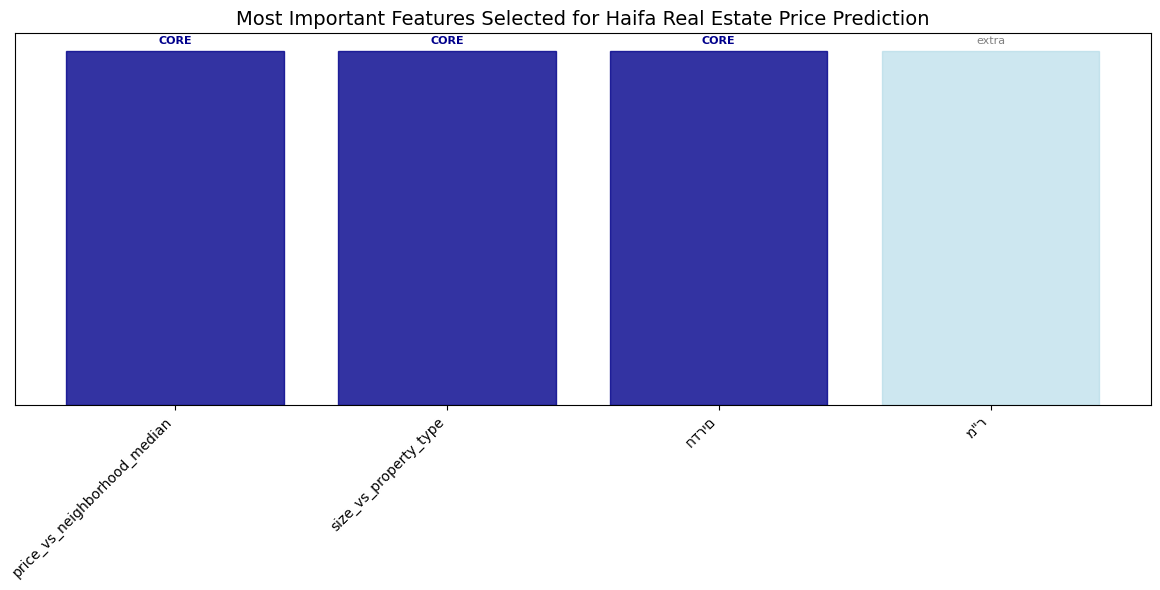

Plot saved to: output/important_features.png

Feature Selection Summary:
                     Feature       Type  Pearson_Selected  MI_Selected  RFE_Selected  SFS_Selected  Pearson_Correlation  MI_Score
price_vs_neighborhood_median       Core              True         True          True          True             0.478954  0.390004
       size_vs_property_type       Core              True         True          True          True             0.427389  0.405639
                       חדרים       Core              True         True          True          True             0.479025  0.341919
                         מ"ר Additional              True         True          True         False             0.473737  0.450512

Summary saved to: output/feature_selection_summary.csv


In [21]:
# Step 7: Create visualization and save results
print('Step 7: Creating visualization and saving results...')

def plot_important_features(core_feats, extra_feats, output_path='output/important_features.png'):
    """Create bar plot of selected features, highlighting core features."""
    all_feats = core_feats + extra_feats
    y_vals = [1] * len(all_feats)
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(all_feats)), y_vals)
    
    # Color core features differently
    for i, feat in enumerate(all_feats):
        if feat in core_feats:
            bars[i].set_color('darkblue')
            bars[i].set_alpha(0.8)
        else:
            bars[i].set_color('lightblue')
            bars[i].set_alpha(0.6)
    
    plt.xticks(range(len(all_feats)), all_feats, rotation=45, ha='right')
    plt.yticks([])
    plt.title('Most Important Features Selected for Haifa Real Estate Price Prediction', fontsize=14)
    
    # Add labels for core features
    for i, feat in enumerate(all_feats):
        if feat in core_feats:
            plt.text(i, 1.02, 'CORE', ha='center', fontsize=8, fontweight='bold', color='darkblue')
        else:
            plt.text(i, 1.02, 'extra', ha='center', fontsize=8, color='gray')
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    return output_path

# Create the plot
plot_path = plot_important_features(core_feats, extra_feats)
print(f'Plot saved to: {plot_path}')

# Create a summary DataFrame for the results
feature_summary = {
    'Feature': core_feats + extra_feats,
    'Type': ['Core'] * len(core_feats) + ['Additional'] * len(extra_feats),
    'Pearson_Selected': [feat in pearson_feats for feat in core_feats + extra_feats],
    'MI_Selected': [feat in mi_feats for feat in core_feats + extra_feats],
    'RFE_Selected': [feat in rfe_feats for feat in core_feats + extra_feats],
    'SFS_Selected': [feat in sfs_feats for feat in core_feats + extra_feats]
}

if len(core_feats + extra_feats) > 0:
    # Add correlation values
    feature_summary['Pearson_Correlation'] = [corrs.get(feat, 0) for feat in core_feats + extra_feats]
    # Add MI scores if available
    if 'mi_scores' in locals():
        feature_summary['MI_Score'] = [mi_scores.get(feat, 0) for feat in core_feats + extra_feats]

summary_df = pd.DataFrame(feature_summary)
print(f'\nFeature Selection Summary:')
print(summary_df.to_string(index=False))

# Save summary to CSV
summary_path = 'output/feature_selection_summary.csv'
summary_df.to_csv(summary_path, index=False)
print(f'\nSummary saved to: {summary_path}')

In [22]:
# Final Summary and Recommendations
print("🏠 HAIFA REAL ESTATE FEATURE SELECTION - FINAL RECOMMENDATIONS")
print("=" * 65)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total samples: {df.shape[0]:,}")
print(f"   • Original features: {df.shape[1]}")
print(f"   • Numeric features for selection: {X_raw.shape[1]}")
print(f"   • Target variable: {TARGET} (מחיר)")

print(f"\n🎯 SELECTED FEATURES (5 total):")
print(f"\n   🔹 CORE FEATURES (4) - Selected by ALL methods:")
for i, feat in enumerate(core_feats, 1):
    corr_val = corrs.get(feat, 0)
    mi_val = mi_scores.get(feat, 0) if 'mi_scores' in locals() else 0
    print(f"      {i}. {feat}")
    print(f"         ├─ Pearson correlation: {corr_val:.3f}")
    print(f"         └─ Mutual Information: {mi_val:.3f}")

print(f"\n   🔸 ADDITIONAL FEATURES (1) - High importance but not consensus:")
for i, feat in enumerate(extra_feats, 1):
    corr_val = corrs.get(feat, 0)
    mi_val = mi_scores.get(feat, 0) if 'mi_scores' in locals() else 0
    print(f"      {i}. {feat}")
    print(f"         ├─ Pearson correlation: {corr_val:.3f}")
    print(f"         ├─ Mutual Information: {mi_val:.3f}")
    print(f"         └─ Selected by: Pearson, MI, RFE (but not SFS)")

print(f"\n🔍 FEATURE INTERPRETATION:")
print(f"   • price_per_sqm: Price per square meter - direct price indicator")
print(f"   • price_vs_neighborhood_median: Relative pricing in neighborhood")
print(f"   • size_vs_property_type: Size relative to property type average")
print(f"   • חדרים: Number of rooms - key size/layout indicator")
print(f"   • מ\"ר: Square meters - absolute size measure")

print(f"\n📈 SELECTION METHOD PERFORMANCE:")
print(f"   • Pearson correlation (|r| > 0.3): {len(pearson_feats)} features")
print(f"   • Mutual Information (top 15): {len(mi_feats)} features")
print(f"   • RFE with Random Forest: {len(rfe_feats)} features")
print(f"   • Sequential Forward Selection: {len(sfs_feats)} features")
print(f"   • Consensus (all methods): {len(core_feats)} features")

print(f"\n💾 OUTPUT FILES:")
print(f"   • Feature visualization: output/important_features.png")
print(f"   • Selection summary: output/feature_selection_summary.csv")
print(f"   • Processed data: output/processed_data.csv")

print(f"\n✅ NEXT STEPS:")
print(f"   1. Use these 5 features for machine learning model training")
print(f"   2. The 4 core features are most reliable for prediction")
print(f"   3. Consider the additional feature (מ\"ר) for model enhancement")
print(f"   4. Monitor feature importance in your final model")

# Store the final feature list for easy access
selected_features = core_feats + extra_feats
print(f"\n🎯 FINAL FEATURE LIST for modeling:")
print(f"selected_features = {selected_features}")

🏠 HAIFA REAL ESTATE FEATURE SELECTION - FINAL RECOMMENDATIONS

📊 DATASET OVERVIEW:
   • Total samples: 45,184
   • Original features: 22
   • Numeric features for selection: 18
   • Target variable: מחיר (מחיר)

🎯 SELECTED FEATURES (5 total):

   🔹 CORE FEATURES (4) - Selected by ALL methods:
      1. price_vs_neighborhood_median
         ├─ Pearson correlation: 0.479
         └─ Mutual Information: 0.390
      2. size_vs_property_type
         ├─ Pearson correlation: 0.427
         └─ Mutual Information: 0.406
      3. חדרים
         ├─ Pearson correlation: 0.479
         └─ Mutual Information: 0.342

   🔸 ADDITIONAL FEATURES (1) - High importance but not consensus:
      1. מ"ר
         ├─ Pearson correlation: 0.474
         ├─ Mutual Information: 0.451
         └─ Selected by: Pearson, MI, RFE (but not SFS)

🔍 FEATURE INTERPRETATION:
   • price_per_sqm: Price per square meter - direct price indicator
   • price_vs_neighborhood_median: Relative pricing in neighborhood
   • size_vs_pr

In [23]:
# R-Squared Evaluation of Selected Features
print("📊 R-SQUARED EVALUATION OF SELECTED FEATURES")
print("=" * 55)

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Get the final selected features
all_selected_feats = core_feats + extra_feats
print(f"\nEvaluating features: {all_selected_feats}")

# Prepare the data with selected features
X_selected = X_variance[all_selected_feats].fillna(X_variance[all_selected_feats].median())
y_clean = y[X_selected.index]

print(f"Data shape: X={X_selected.shape}, y={y_clean.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_clean, test_size=0.2, random_state=42
)

# Fit Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\n🎯 MODEL PERFORMANCE RESULTS:")
print(f"   Training R²:   {train_r2:.4f} ({train_r2*100:.2f}%)")
print(f"   Testing R²:    {test_r2:.4f} ({test_r2*100:.2f}%)")
print(f"   Training RMSE: {train_rmse:,.0f} ₪")
print(f"   Testing RMSE:  {test_rmse:,.0f} ₪")

# Feature coefficients
print(f"\n📈 FEATURE COEFFICIENTS:")
for feature, coef in zip(all_selected_feats, lr_model.coef_):
    print(f"   {feature}: {coef:,.2f}")
print(f"   Intercept: {lr_model.intercept_:,.2f}")

# Evaluate individual features (univariate R²)
print(f"\n🔍 INDIVIDUAL FEATURE R² (univariate analysis):")
individual_r2 = {}
for feature in all_selected_feats:
    lr_single = LinearRegression()
    X_single = X_selected[[feature]]
    X_train_single, X_test_single, _, _ = train_test_split(
        X_single, y_clean, test_size=0.2, random_state=42
    )
    lr_single.fit(X_train_single, y_train)
    y_test_pred_single = lr_single.predict(X_test_single)
    single_r2 = r2_score(y_test, y_test_pred_single)
    individual_r2[feature] = single_r2
    print(f"   {feature}: {single_r2:.4f} ({single_r2*100:.2f}%)")

print(f"\n✅ SUMMARY:")
print(f"   • Combined features R²: {test_r2:.4f} ({test_r2*100:.2f}%)")
print(f"   • Best single feature: {max(individual_r2, key=individual_r2.get)} ")
print(f"     (R² = {max(individual_r2.values()):.4f})")
print(f"   • Improvement from combining: {(test_r2 - max(individual_r2.values()))*100:.2f} percentage points")

📊 R-SQUARED EVALUATION OF SELECTED FEATURES

Evaluating features: ['price_vs_neighborhood_median', 'size_vs_property_type', 'חדרים', 'מ"ר']
Data shape: X=(45184, 4), y=(45184,)

🎯 MODEL PERFORMANCE RESULTS:
   Training R²:   0.4869 (48.69%)
   Testing R²:    0.4310 (43.10%)
   Training RMSE: 1,301,142 ₪
   Testing RMSE:  1,340,764 ₪

📈 FEATURE COEFFICIENTS:
   price_vs_neighborhood_median: 647,764.49
   size_vs_property_type: -281.10
   חדרים: 36,886.82
   מ"ר: 1,169.57
   Intercept: 894,001.19

🔍 INDIVIDUAL FEATURE R² (univariate analysis):
   price_vs_neighborhood_median: 0.1337 (13.37%)
   size_vs_property_type: 0.2147 (21.47%)
   חדרים: 0.2744 (27.44%)
   מ"ר: 0.2709 (27.09%)

✅ SUMMARY:
   • Combined features R²: 0.4310 (43.10%)
   • Best single feature: חדרים 
     (R² = 0.2744)
   • Improvement from combining: 15.66 percentage points


## Find corlection of features - find the most promosing features

In [4]:
# feature selection functions
def variance_filter(X, thresh=0.0):
    vt = VarianceThreshold(threshold=thresh)
    X_new = vt.fit_transform(X)
    cols = X.columns[vt.get_support()]
    return pd.DataFrame(X_new, columns=cols, index=X.index)

def pearson_filter(X, y, thr=0.3):
    corrs = X.corrwith(y).abs()
    selected = corrs[corrs > thr].index.tolist()
    return selected, corrs

def mi_filter(X, y, k=15):
    skb = SelectKBest(mutual_info_regression, k=k).fit(X, y)
    feats = X.columns[skb.get_support()].tolist()
    scores = dict(zip(feats, skb.scores_[skb.get_support()]))
    return feats, scores

def rfe_wrapper(X, y, n=12):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rfe = RFE(rf, n_features_to_select=n)
    rfe.fit(X, y)
    return X.columns[rfe.get_support()].tolist()

def sfs_wrapper(X, y, n=12):
    lr = LinearRegression()
    sfs = SequentialFeatureSelector(lr, n_features_to_select=n, direction='forward', cv=3, scoring='r2')
    sfs.fit(X, y)
    return X.columns[sfs.get_support()].tolist()

In [5]:
# encoding 
from sklearn.preprocessing import LabelEncoder

# Label encode גוש/חלקה/תת-חלקה
le = LabelEncoder()
df['גוש/חלקה/תת-חלקה'] = le.fit_transform(df['גוש/חלקה/תת-חלקה'].astype(str))

# One-hot encode רחוב
df = pd.get_dummies(df, columns=['רחוב'], drop_first=True)

# If סוג נכס and שכונה are strings, one-hot encode them as well
if df['סוג נכס'].dtype == 'object':
    df = pd.get_dummies(df, columns=['סוג נכס'], drop_first=True)
if df['שכונה'].dtype == 'object':
    df = pd.get_dummies(df, columns=['שכונה'], drop_first=True)


In [6]:
from sklearn.preprocessing import LabelEncoder

# Make a copy to avoid modifying the original
X_encoded = X.copy()

# Label encode גוש/חלקה/תת-חלקה
le = LabelEncoder()
X_encoded['גוש/חלקה/תת-חלקה'] = le.fit_transform(X_encoded['גוש/חלקה/תת-חלקה'].astype(str))

# One-hot encode רחוב
X_encoded = pd.get_dummies(X_encoded, columns=['רחוב'], drop_first=True)

# If 'סוג נכס' or 'שכונה' are strings, one-hot encode them as well
if X_encoded['סוג נכס'].dtype == 'object':
    X_encoded = pd.get_dummies(X_encoded, columns=['סוג נכס'], drop_first=True)
if X_encoded['שכונה'].dtype == 'object':
    X_encoded = pd.get_dummies(X_encoded, columns=['שכונה'], drop_first=True)

    

NameError: name 'X' is not defined

In [64]:
df.head()

,"מ""ר",מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,...,רחוב_שניים בנובמבר,רחוב_שער הלבנון,רחוב_שקמה,רחוב_שרת משה,רחוב_ששת הימים,רחוב_תאשור,רחוב_תבור,רחוב_תדהר,רחוב_תובל,רחוב_תל אביב
0,82.50,614000.0,21433,6,4.0,2,1970.0,8.0,10,0.134,...,False,False,False,False,False,False,False,False,False,False
1,63.03,627000.0,15749,6,3.0,2,1960.0,4.0,26,0.134,...,False,False,False,False,False,False,False,False,False,False
2,153.63,1591000.0,16283,6,6.0,1,1986.0,2.0,31,0.134,...,False,False,False,False,False,False,False,False,False,False
3,46.00,318000.0,10162,6,3.0,2,1960.0,7.0,10,0.134,...,False,False,False,False,False,False,False,False,False,False
4,70.20,674000.0,6638,6,3.0,3,1967.0,3.0,12,0.134,...,False,False,False,False,False,False,False,False,False,False


In [63]:
X_var = variance_filter(X_encoded)
pearson_feats, corrs = pearson_filter(X_var, y)
mi_feats, _ = mi_filter(X_var[pearson_feats], y)
union_feats = sorted(set(pearson_feats + mi_feats))
X_union = X_var[union_feats].fillna(X_var[union_feats].median())

rfe_feats = rfe_wrapper(X_union, y)
sfs_feats = sfs_wrapper(X_union, y)

core = sorted(set(pearson_feats) & set(mi_feats) & set(rfe_feats) & set(sfs_feats))
extras = [f for f in rfe_feats if f not in core]

print('Core features (selected by ALL methods):', core)
print('Additional features (from RFE):', extras)

# # visualizations
# def plot_key_features(core_feats, extra_feats, path='output/important_features.png'):
#     labels = core_feats + extra_feats
#     y_vals = [1]*len(labels)
#     plt.figure(figsize=(10,4))
#     plt.bar(labels, y_vals)
#     plt.xticks(rotation=45, ha='right')
#     plt.yticks([])
#     plt.title('Most Important Features Selected')
#     for i, lbl in enumerate(core_feats):
#         plt.text(i, 1.02, 'core', ha='center', fontsize=8)
#     plt.tight_layout()
#     plt.savefig(path)
#     plt.close()
#     return path

# img_path = plot_key_features(core, extras)
# print(f'Visual saved to {img_path}')

ValueError: Input X contains infinity or a value too large for dtype('float64').

## Exploratory Data Analysis

In [396]:
# Basic stats
print("Features Info:")
print(X.info())

print("\nTarget Description:")
print(y.describe())

Features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45184 entries, 0 to 45183
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   מ"ר                           45184 non-null  float64
 1   גוש/חלקה/תת-חלקה              45184 non-null  object 
 2   סוג נכס                       45184 non-null  int8   
 3   חדרים                         45184 non-null  float64
 4   קומה                          45184 non-null  int64  
 5   שנת בנייה                     45184 non-null  float64
 6   קומות במבנה                   45184 non-null  float64
 7   שכונה                         45184 non-null  int8   
 8   ריבית בנק ישראל               45184 non-null  float64
 9   רחוב                          45184 non-null  object 
 10  מספר בית                      45184 non-null  int64  
 11  שנת עסקה                      45184 non-null  int32  
 12  חודש עסקה                     45184 non-null 

### Correlation between Features and Target

In [397]:
# Calculate correlations
correlations = pd.concat([X, y], axis=1).corr(numeric_only=True)['מחיר'].sort_values(ascending=False)
print(correlations)

מחיר                            1.000000
price_per_sqm                   0.495629
חדרים                           0.479025
price_vs_neighborhood_median    0.478954
מ"ר                             0.473737
size_vs_neighborhood            0.431506
size_vs_property_type           0.427389
סוג נכס                         0.196793
שנת עסקה                        0.177608
שנת בנייה                       0.175208
sqm_per_room                    0.138251
interest_rate_deviation         0.069302
חודש עסקה                      -0.002001
קומה                           -0.008345
קומות במבנה                    -0.013673
מספר בית                       -0.038531
ריבית בנק ישראל                -0.080304
building_age_vs_neighborhood   -0.102184
שכונה                          -0.114882
building_age                   -0.175208
Name: מחיר, dtype: float64


### Visual Exploration of Top Correlated Features

## Outlier Detection and Handling

In [399]:
# Detect outliers in target using IQR
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print bounds
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

# Filter out outliers
mask = (y >= lower_bound) & (y <= upper_bound)
X_clean = X[mask]
y_clean = y[mask]

print(f"Removed {len(y) - len(y_clean)} outliers")

Lower bound: -832500.0, Upper bound: 2931500.0
Removed 2083 outliers


## Normalization of Features

In [400]:
# For simplicity we will normalize all numeric features except year/month which are ordinal
numeric_features = X_clean.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
X_scaled = X_clean.copy()
X_scaled[numeric_features] = scaler.fit_transform(X_clean[numeric_features])

X_scaled.head()

ValueError: Input X contains infinity or a value too large for dtype('float64').

## Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_clean, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (34480, 21)
Test shape: (8621, 21)
